In [146]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
%matplotlib inline

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [147]:
try:
    train_df = pd.read_csv('train_data.csv')
    val_df = pd.read_csv('val_data.csv')
    test_df = pd.read_csv('test_data.csv')
except FileNotFoundError as e:
    print(f"Error: {e}. Ensure 'train_data.csv', 'val_data.csv', and 'test_data.csv' are in {os.getcwd()}")
    raise


In [148]:
train_df = train_df.fillna(0)
val_df = val_df.fillna(0)
test_df = test_df.fillna(0)

In [149]:
try:
    y_train = train_df['RemainingLaps']
    X_train_flat = train_df.drop('RemainingLaps', axis=1)
    y_val = val_df['RemainingLaps']
    X_val_flat = val_df.drop('RemainingLaps', axis=1)
    y_test = test_df['RemainingLaps']
    X_test_flat = test_df.drop('RemainingLaps', axis=1)
except KeyError as e:
    print(f"Error: {e}. Ensure 'RemainingLaps' column exists in all CSV files. Columns found in train_data.csv: {train_df.columns.tolist()}")
    raise

In [150]:
window_size = 2
try:
    N = X_train_flat.shape[1] // window_size
    assert X_train_flat.shape[1] % window_size == 0, f"Number of feature columns ({X_train_flat.shape[1]}) must be divisible by window_size ({window_size})"
except AssertionError as e:
    print(f"Error: {e}. Check feature columns in CSV files.")
    raise


In [151]:
def r2_score(y_true, y_pred):
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2.item()

In [ ]:
X_train = X_train_flat.values.reshape(-1, window_size, N)
X_val = X_val_flat.values.reshape(-1, window_size, N)
X_test = X_test_flat.values.reshape(-1, window_size, N)

for col in X_train_flat.columns:
    if X_train_flat[col].dtype == bool:
        X_train_flat[col] = X_train_flat[col].astype('float32')
        
for col in X_val_flat.columns:
    if X_val_flat[col].dtype == bool:
        X_val_flat[col] = X_val_flat[col].astype('float32')

for col in X_test_flat.columns:
    if X_test_flat[col].dtype == bool:
        X_test_flat[col] = X_test_flat[col].astype('float32')
        
print("Data types in X_train_flat:")
print(X_train_flat.dtypes)

print("Type of y_train:", type(y_train))
print("y_train content:", y_train)

X_train = X_train_flat.values.reshape(-1, window_size, N)
X_val = X_val_flat.values.reshape(-1, window_size, N)
X_test = X_test_flat.values.reshape(-1, window_size, N)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val.values, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device)

Data types in X_train_flat:
LapTime_t1        float64
Sector1Time_t1    float64
Sector2Time_t1    float64
Sector3Time_t1    float64
SpeedI1_t1        float64
                   ...   
Driver_STR_t2     float32
Driver_TSU_t2     float32
Driver_VER_t2     float32
Driver_VET_t2     float32
Driver_ZHO_t2     float32
Length: 162, dtype: object
Type of y_train: <class 'pandas.core.series.Series'>
y_train content: 0        11.0
1        10.0
2         9.0
3         8.0
4         7.0
         ... 
43270     4.0
43271     3.0
43272     2.0
43273     1.0
43274     0.0
Name: RemainingLaps, Length: 43275, dtype: float64


In [153]:
assert not torch.isnan(X_train).any(), "NaN values detected in X_train after filling"
assert not torch.isnan(y_train).any(), "NaN values detected in y_train after filling"
assert not torch.isnan(X_val).any(), "NaN values detected in X_val after filling"
assert not torch.isnan(y_val).any(), "NaN values detected in y_val after filling"
assert not torch.isnan(X_test).any(), "NaN values detected in X_test after filling"
assert not torch.isnan(y_test).any(), "NaN values detected in y_test after filling"

In [154]:
class TireStintLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(TireStintLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout1 = nn.Dropout(0.4)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout2 = nn.Dropout(0.4)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout3 = nn.Dropout(0.4)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        out, _ = self.lstm3(out)
        out = self.dropout3(out[:, -1, :])
        out = self.fc(out)
        return out

In [155]:
model = TireStintLSTM(input_size=N, hidden_size=64).to(device)
print(model)

TireStintLSTM(
  (lstm1): LSTM(81, 64, batch_first=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (lstm2): LSTM(64, 64, batch_first=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (lstm3): LSTM(64, 64, batch_first=True)
  (dropout3): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [156]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-5)

In [ ]:
num_epochs = 1000 
train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []
patience = 5
patience_counter = 0
best_val_loss = float('inf')
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs.squeeze(), y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    with torch.no_grad():
        train_r2 = r2_score(y_train, outputs.squeeze())
        train_r2_scores.append(train_r2)
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs.squeeze(), y_val)
        val_losses.append(val_loss.item())
        val_r2 = r2_score(y_val, val_outputs.squeeze())
        val_r2_scores.append(val_r2)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Train R²: {train_r2:.4f}, Val R²: {val_r2:.4f}")

# Restore best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)

Epoch 1/1000, Train Loss: 247.6047, Val Loss: 305.3941, Train R²: -1.5142, Val R²: -1.3599
Epoch 2/1000, Train Loss: 247.1527, Val Loss: 304.8987, Train R²: -1.5096, Val R²: -1.3560
Epoch 3/1000, Train Loss: 246.7116, Val Loss: 304.3955, Train R²: -1.5051, Val R²: -1.3521
Epoch 4/1000, Train Loss: 246.2504, Val Loss: 303.8778, Train R²: -1.5004, Val R²: -1.3481
Epoch 5/1000, Train Loss: 245.7880, Val Loss: 303.3383, Train R²: -1.4957, Val R²: -1.3440
Epoch 6/1000, Train Loss: 245.2994, Val Loss: 302.7698, Train R²: -1.4908, Val R²: -1.3396
Epoch 7/1000, Train Loss: 244.7892, Val Loss: 302.1645, Train R²: -1.4856, Val R²: -1.3349
Epoch 8/1000, Train Loss: 244.2558, Val Loss: 301.5141, Train R²: -1.4802, Val R²: -1.3299
Epoch 9/1000, Train Loss: 243.6751, Val Loss: 300.8093, Train R²: -1.4743, Val R²: -1.3244
Epoch 10/1000, Train Loss: 243.0360, Val Loss: 300.0398, Train R²: -1.4678, Val R²: -1.3185
Epoch 11/1000, Train Loss: 242.3617, Val Loss: 299.1937, Train R²: -1.4610, Val R²: -1.31

In [158]:
if best_model_state is not None:
    model.load_state_dict(best_model_state)

In [159]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs.squeeze(), y_test)
    test_r2 = r2_score(y_test, test_outputs.squeeze())
print(f"Test Loss (MSE): {test_loss.item():.4f}")
print(f"Test R²: {test_r2:.4f}")


Test Loss (MSE): 12.8782
Test R²: 0.8862


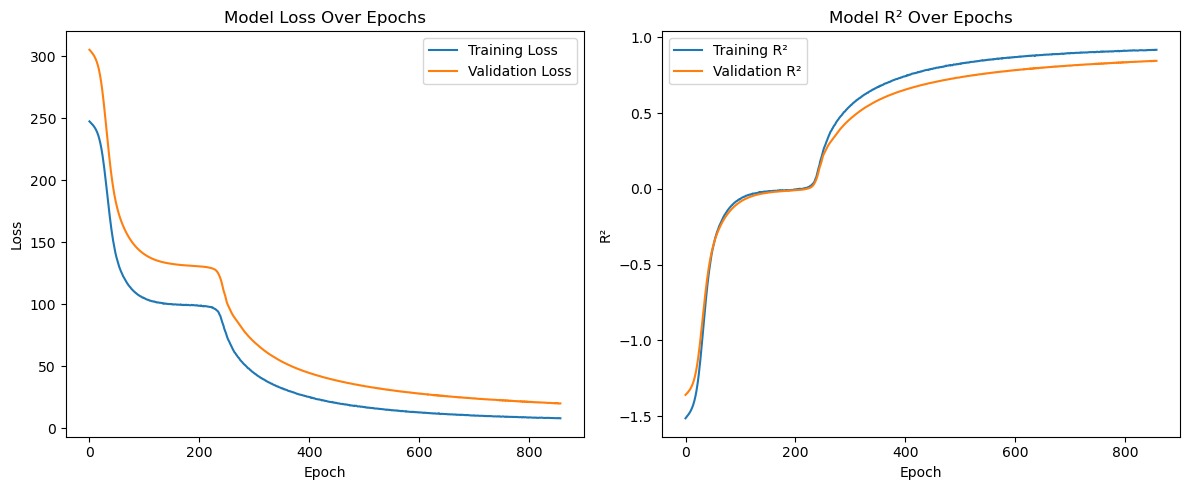

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_r2_scores, label='Training R²')
plt.plot(val_r2_scores, label='Validation R²')
plt.title('Model R² Over Epochs')
plt.ylabel('R²')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [161]:
torch.save(model.state_dict(), 'tire_stint_model_pytorch.pth')
print("Model saved as 'tire_stint_model_pytorch.pth'")

Model saved as 'tire_stint_model_pytorch.pth'


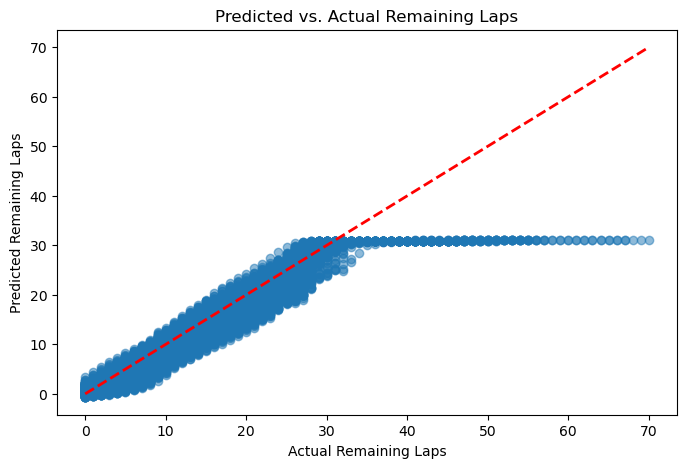

In [ ]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_pred = test_outputs.squeeze().cpu().numpy()
    y_test_np = y_test.cpu().numpy()

plt.figure(figsize=(8, 5))
plt.scatter(y_test_np, test_pred, alpha=0.5)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--', lw=2)
plt.title('Predicted vs. Actual Remaining Laps')
plt.xlabel('Actual Remaining Laps')
plt.ylabel('Predicted Remaining Laps')
plt.show()

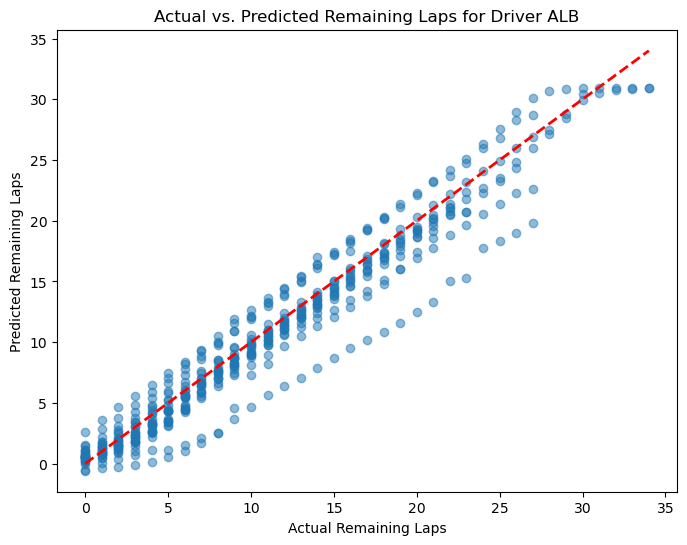

In [ ]:
driver_col = 'Driver_ALB'
feature_cols = ['LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'TyreLife', 'Position', 'StintLapNumber', 'time_tire_stint', 'StartingTyreLife', 'Avg_AirTemp', 'Max_TrackTemp', 'Avg_Humidity', 'Max_Rainfall', 'Avg_WindSpeed', 'LapNumber', 'Compound_HARD', 'Compound_INTERMEDIATE', 'Compound_MEDIUM', 'Compound_SOFT', 'Compound_WET', 'FreshTyre_False', 'FreshTyre_True', 'Circuit_Austin', 'Circuit_Baku', 'Circuit_Barcelona', 'Circuit_Budapest', 'Circuit_Imola', 'Circuit_Jeddah', 'Circuit_Las Vegas', 'Circuit_Le Castellet', 'Circuit_Lusail', 'Circuit_Marina Bay', 'Circuit_Melbourne', 'Circuit_Mexico City', 'Circuit_Miami', 'Circuit_Monaco', 'Circuit_Montréal', 'Circuit_Monza', 'Circuit_Sakhir', 'Circuit_Shanghai', 'Circuit_Silverstone', 'Circuit_Spa-Francorchamps', 'Circuit_Spielberg', 'Circuit_Suzuka', 'Circuit_São Paulo', 'Circuit_Zandvoort', 'Driver_ALB', 'Driver_ALO', 'Driver_BEA', 'Driver_BOT', 'Driver_COL', 'Driver_DEV', 'Driver_GAS', 'Driver_HAM', 'Driver_HUL', 'Driver_LAT', 'Driver_LAW', 'Driver_LEC', 'Driver_MAG', 'Driver_MSC', 'Driver_NOR', 'Driver_OCO', 'Driver_PER', 'Driver_PIA', 'Driver_RIC', 'Driver_RUS', 'Driver_SAI', 'Driver_SAR', 'Driver_STR', 'Driver_TSU', 'Driver_VER', 'Driver_VET', 'Driver_ZHO']

if driver_col not in feature_cols:
    print(f"Driver column '{driver_col}' not found in feature_cols: {feature_cols}")
else:
    driver_idx = (X_test[:, 0, feature_cols.index(driver_col)] == 1).nonzero(as_tuple=True)[0]
    if len(driver_idx) > 0:
        y_actual = y_test[driver_idx].cpu().numpy()
        with torch.no_grad():
            y_pred = model(X_test[driver_idx]).squeeze().cpu().numpy()
        plt.figure(figsize=(8, 6))
        plt.scatter(y_actual, y_pred, alpha=0.5)
        plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)
        plt.xlabel('Actual Remaining Laps')
        plt.ylabel('Predicted Remaining Laps')
        plt.title(f'Actual vs. Predicted Remaining Laps for Driver {driver_col.split("_")[1]}')
        plt.show()
    

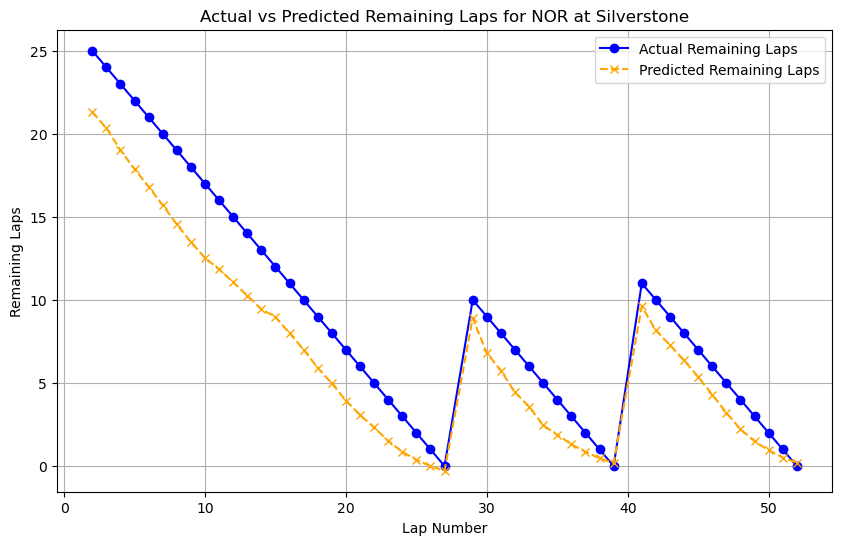

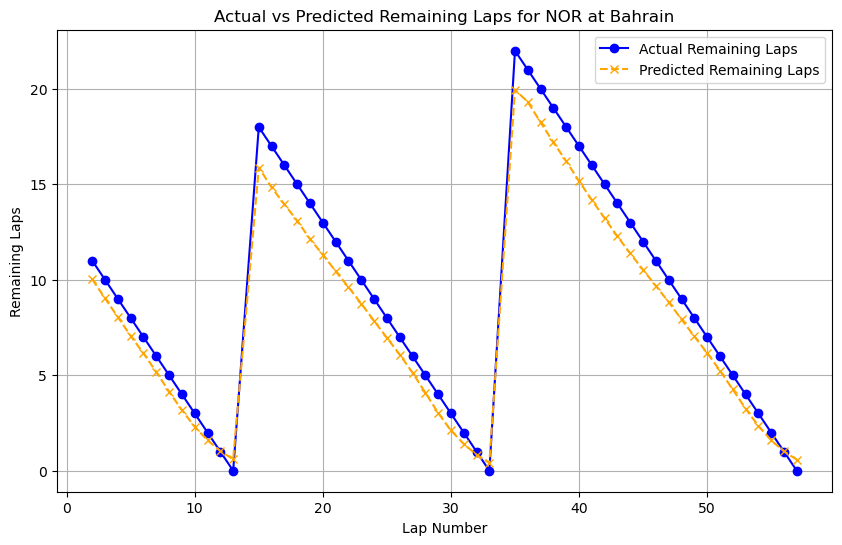

In [166]:


# Define feature_cols as provided
feature_cols = [
    'LapTime_t1', 'Sector1Time_t1', 'Sector2Time_t1', 'Sector3Time_t1', 'SpeedI1_t1', 'SpeedI2_t1', 
    'SpeedFL_t1', 'SpeedST_t1', 'TyreLife_t1', 'Position_t1', 'StintLapNumber_t1', 'time_tire_stint_t1', 
    'StartingTyreLife_t1', 'Avg_AirTemp_t1', 'Max_TrackTemp_t1', 'Avg_Humidity_t1', 'Max_Rainfall_t1', 
    'Avg_WindSpeed_t1', 'LapNumber_t1', 'Compound_HARD_t1', 'Compound_INTERMEDIATE_t1', 'Compound_MEDIUM_t1', 
    'Compound_SOFT_t1', 'Compound_WET_t1', 'FreshTyre_False_t1', 'FreshTyre_True_t1', 'Circuit_Austin_t1', 
    'Circuit_Baku_t1', 'Circuit_Barcelona_t1', 'Circuit_Budapest_t1', 'Circuit_Imola_t1', 'Circuit_Jeddah_t1', 
    'Circuit_Las Vegas_t1', 'Circuit_Le Castellet_t1', 'Circuit_Lusail_t1', 'Circuit_Marina Bay_t1', 
    'Circuit_Melbourne_t1', 'Circuit_Mexico City_t1', 'Circuit_Miami_t1', 'Circuit_Monaco_t1', 
    'Circuit_Montréal_t1', 'Circuit_Monza_t1', 'Circuit_Sakhir_t1', 'Circuit_Shanghai_t1', 
    'Circuit_Silverstone_t1', 'Circuit_Spa-Francorchamps_t1', 'Circuit_Spielberg_t1', 'Circuit_Suzuka_t1', 
    'Circuit_São Paulo_t1', 'Circuit_Zandvoort_t1', 'Driver_ALB_t1', 'Driver_ALO_t1', 'Driver_ANT_t1', 
    'Driver_BEA_t1', 'Driver_BOR_t1', 'Driver_BOT_t1', 'Driver_COL_t1', 'Driver_DEV_t1', 'Driver_DOO_t1', 
    'Driver_GAS_t1', 'Driver_HAD_t1', 'Driver_HAM_t1', 'Driver_HUL_t1', 'Driver_LAT_t1', 'Driver_LAW_t1', 
    'Driver_LEC_t1', 'Driver_MAG_t1', 'Driver_MSC_t1', 'Driver_NOR_t1', 'Driver_OCO_t1', 'Driver_PER_t1', 
    'Driver_PIA_t1', 'Driver_RIC_t1', 'Driver_RUS_t1', 'Driver_SAI_t1', 'Driver_SAR_t1', 'Driver_STR_t1', 
    'Driver_TSU_t1', 'Driver_VER_t1', 'Driver_VET_t1', 'Driver_ZHO_t1', 
    'LapTime_t2', 'Sector1Time_t2', 'Sector2Time_t2', 'Sector3Time_t2', 'SpeedI1_t2', 'SpeedI2_t2', 
    'SpeedFL_t2', 'SpeedST_t2', 'TyreLife_t2', 'Position_t2', 'StintLapNumber_t2', 'time_tire_stint_t2', 
    'StartingTyreLife_t2', 'Avg_AirTemp_t2', 'Max_TrackTemp_t2', 'Avg_Humidity_t2', 'Max_Rainfall_t2', 
    'Avg_WindSpeed_t2', 'LapNumber_t2', 'Compound_HARD_t2', 'Compound_INTERMEDIATE_t2', 'Compound_MEDIUM_t2', 
    'Compound_SOFT_t2', 'Compound_WET_t2', 'FreshTyre_False_t2', 'FreshTyre_True_t2', 'Circuit_Austin_t2', 
    'Circuit_Baku_t2', 'Circuit_Barcelona_t2', 'Circuit_Budapest_t2', 'Circuit_Imola_t2', 'Circuit_Jeddah_t2', 
    'Circuit_Las Vegas_t2', 'Circuit_Le Castellet_t2', 'Circuit_Lusail_t2', 'Circuit_Marina Bay_t2', 
    'Circuit_Melbourne_t2', 'Circuit_Mexico City_t2', 'Circuit_Miami_t2', 'Circuit_Monaco_t2', 
    'Circuit_Montréal_t2', 'Circuit_Monza_t2', 'Circuit_Sakhir_t2', 'Circuit_Shanghai_t2', 
    'Circuit_Silverstone_t2', 'Circuit_Spa-Francorchamps_t2', 'Circuit_Spielberg_t2', 'Circuit_Suzuka_t2', 
    'Circuit_São Paulo_t2', 'Circuit_Zandvoort_t2', 'Driver_ALB_t2', 'Driver_ALO_t2', 'Driver_ANT_t2', 
    'Driver_BEA_t2', 'Driver_BOR_t2', 'Driver_BOT_t2', 'Driver_COL_t2', 'Driver_DEV_t2', 'Driver_DOO_t2', 
    'Driver_GAS_t2', 'Driver_HAD_t2', 'Driver_HAM_t2', 'Driver_HUL_t2', 'Driver_LAT_t2', 'Driver_LAW_t2', 
    'Driver_LEC_t2', 'Driver_MAG_t2', 'Driver_MSC_t2', 'Driver_NOR_t2', 'Driver_OCO_t2', 'Driver_PER_t2', 
    'Driver_PIA_t2', 'Driver_RIC_t2', 'Driver_RUS_t2', 'Driver_SAI_t2', 'Driver_SAR_t2', 'Driver_STR_t2', 
    'Driver_TSU_t2', 'Driver_VER_t2', 'Driver_VET_t2', 'Driver_ZHO_t2'
]

base_feature_cols = [col.replace('_t1', '') for col in feature_cols[:81]]

base_d = base_feature_cols.index('Driver_NOR')
base_k = base_feature_cols.index('LapNumber')
base_c_silverstone = base_feature_cols.index('Circuit_Silverstone')
base_c_bahrain = base_feature_cols.index('Circuit_Sakhir')

def plot_remaining_laps(base_circuit_idx, circuit_name):

    idx = (X_val[:, 0, base_d] == 1) & (X_val[:, 0, base_circuit_idx] == 1)
    idx = idx.nonzero(as_tuple=True)[0

    lap_numbers = X_val[idx, 1, base_k].cpu().numpy()
    
    actual = y_val[idx].cpu().numpy()
    
    with torch.no_grad():
        predicted = model(X_val[idx]).squeeze().cpu().numpy()
    
    sorted_idx = np.argsort(lap_numbers)
    lap_numbers = lap_numbers[sorted_idx]
    actual = actual[sorted_idx]
    predicted = predicted[sorted_idx]
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(lap_numbers, actual, label='Actual Remaining Laps', marker='o', linestyle='-', color='blue')
    plt.plot(lap_numbers, predicted, label='Predicted Remaining Laps', marker='x', linestyle='--', color='orange')
    plt.xlabel('Lap Number')
    plt.ylabel('Remaining Laps')
    plt.title(f'Actual vs Predicted Remaining Laps for NOR at {circuit_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Generate plots
plot_remaining_laps(base_c_silverstone, 'Silverstone')
plot_remaining_laps(base_c_bahrain, 'Bahrain')